=== 自相关性分析 (最终修正版) ===


/tmp/ipykernel_3971/1997868044.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


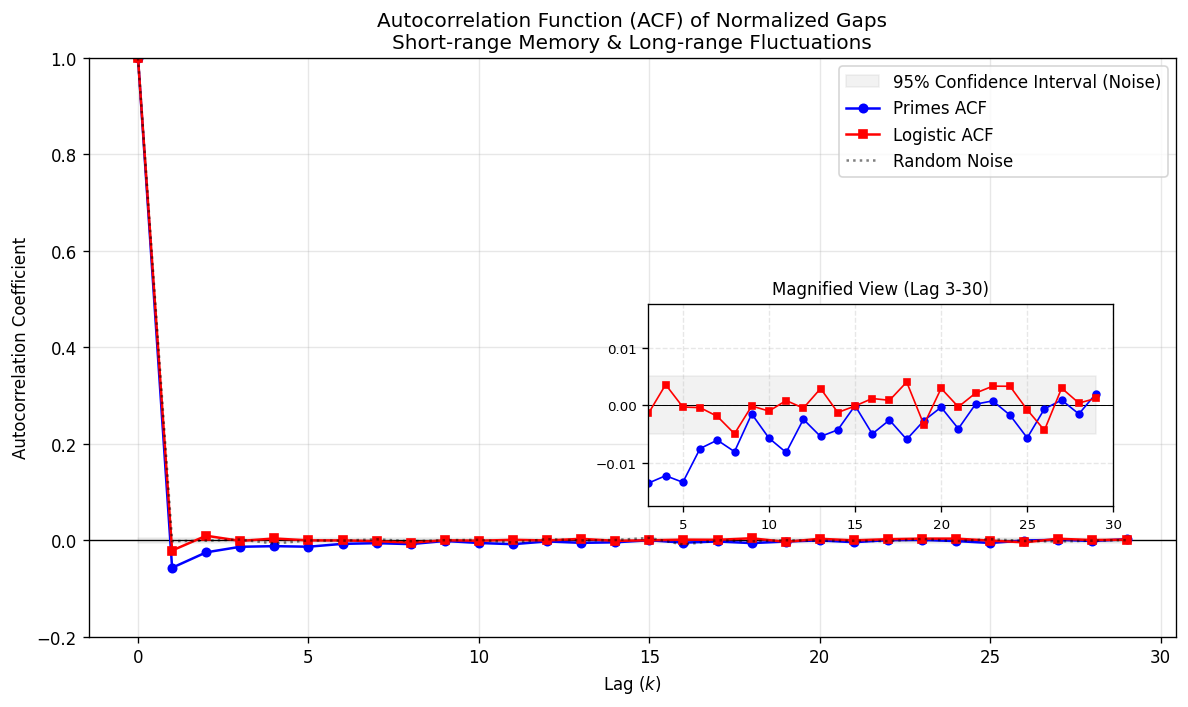

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def analyze_autocorrelation_final(limit=2000000):
    print("=== 自相关性分析 (最终修正版) ===")
    
    # ==========================
    # 1. 数据生成 (保持不变)
    # ==========================
    # A. 真实素数
    sieve = np.ones(limit // 2, dtype=bool)
    for i in range(3, int(limit**0.5) + 1, 2):
        if sieve[i // 2]:
            sieve[i*i // 2 :: i] = False
    primes = np.array([1] + [2 * i + 1 for i in range(1, limit // 2) if sieve[i]])
    gaps_p = np.diff(primes)
    p_vals = primes[:-1].astype(float)
    p_vals[p_vals < 2] = 2
    norm_gaps_p = gaps_p / np.log(p_vals)
    series_p = norm_gaps_p - np.mean(norm_gaps_p)
    
    # B. Logistic 映射
    u = 1.543689012692076
    target_len = len(series_p)
    x = 0.1
    for _ in range(10000): x = 1 - u * x**2
    gaps_l = []
    curr = 0
    max_steps = target_len * 6 
    for _ in range(max_steps):
        x = 1 - u * x**2
        if x < 0:
            if curr > 0: gaps_l.append(curr)
            curr = 1
        else:
            curr += 1
        if len(gaps_l) >= target_len: break
    gaps_l = np.array(gaps_l)
    norm_gaps_l = gaps_l / np.mean(gaps_l)
    series_l = norm_gaps_l - np.mean(norm_gaps_l)
    
    # C. 随机对照组
    series_r = np.random.exponential(1, target_len)
    series_r = series_r - np.mean(series_r)

    # ==========================
    # 2. 计算 ACF
    # ==========================
    def compute_acf(series, lag_max=30):
        n = len(series)
        variance = np.var(series)
        acf = []
        for k in range(lag_max):
            c = np.dot(series[:n-k], series[k:]) / (n - k)
            acf.append(c / variance)
        return np.array(acf)

    MAX_LAG = 30
    acf_p = compute_acf(series_p, MAX_LAG)
    acf_l = compute_acf(series_l, MAX_LAG)
    acf_r = compute_acf(series_r, MAX_LAG)
    
    # ==========================
    # 3. 绘图 (位置调整)
    # ==========================
    fig, ax_main = plt.subplots(figsize=(10, 6), dpi=120)
    lags = np.arange(MAX_LAG)
    
    # --- 主图绘制 ---
    ax_main.axhline(0, color='black', lw=0.8)
    conf_level = 1.96 / np.sqrt(len(series_p))
    ax_main.fill_between(lags, -conf_level, conf_level, color='gray', alpha=0.1, label='95% Confidence Interval (Noise)')
    
    ax_main.plot(lags, acf_p, 'b-o', markersize=5, lw=1.5, label='Primes ACF')
    ax_main.plot(lags, acf_l, 'r-s', markersize=5, lw=1.5, label='Logistic ACF')
    ax_main.plot(lags, acf_r, 'k:', alpha=0.5, label='Random Noise')
    
    ax_main.set_title('Autocorrelation Function (ACF) of Normalized Gaps\nShort-range Memory & Long-range Fluctuations')
    ax_main.set_xlabel('Lag ($k$)')
    ax_main.set_ylabel('Autocorrelation Coefficient')
    ax_main.set_ylim(-0.2, 1.0)
    ax_main.legend(loc='upper right', frameon=True) 
    ax_main.grid(True, alpha=0.3)
    
    # --- 子图 (Inset) 调整位置 ---
    # loc=5 代表 'center right' (右侧居中)，或者 loc=4 'lower right' (右下角)
    # 这里我们用 center right 并稍微往下偏一点，避开右上角的 Legend
    ax_inset = inset_axes(ax_main, width="45%", height="35%", 
                          loc='center right', # 改为右侧居中
                          bbox_to_anchor=(0, -0.1, 0.95, 1), # (x, y, width, height) 相对微调，往下移一点
                          bbox_transform=ax_main.transAxes)
    
    # 在子图中绘制同样的数据
    ax_inset.axhline(0, color='black', lw=0.6)
    ax_inset.fill_between(lags, -conf_level, conf_level, color='gray', alpha=0.1)
    
    ax_inset.plot(lags, acf_p, 'b-o', markersize=4, lw=1)
    ax_inset.plot(lags, acf_l, 'r-s', markersize=4, lw=1)
    
    # 聚焦范围
    ax_inset.set_xlim(3, 30)
    max_fluctuation = max(np.max(np.abs(acf_p[3:])), np.max(np.abs(acf_l[3:])))
    y_limit = max_fluctuation * 1.3 
    ax_inset.set_ylim(-y_limit, y_limit)
    
    ax_inset.set_title('Magnified View (Lag 3-30)', fontsize=10)
    ax_inset.grid(True, alpha=0.3, ls='--')
    ax_inset.tick_params(axis='both', which='major', labelsize=8)
    
    plt.tight_layout()
    plt.savefig('autocorrelation_final.png')
    plt.show()

analyze_autocorrelation_final()